# Intro

Goal of this notebook: 
- familiarising myself with gamma parametrisation. 

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import GammaRegressor


# Gamma Summary

For reference: https://en.wikipedia.org/wiki/Gamma_distribution.

The numpy package's shape and scale parameter are the first parameter set, so $k$ and $\theta$. Mean is $k \theta$. 

# Generate Data

Goal is to visualise different gammas that share the same mean. 

In [5]:
gamma_mean = 10000
number_of_sample = 10000

In [13]:
shape = 1
scale = gamma_mean/shape
df1 = pd.DataFrame.from_dict({'target': np.random.gamma(shape, scale, number_of_sample), 'shape': shape})

In [14]:
shape = 2
scale = gamma_mean/shape
df2 = pd.DataFrame.from_dict({'target': np.random.gamma(shape, scale, number_of_sample), 'shape': shape})

In [15]:
shape = 3
scale = gamma_mean/shape
df3 = pd.DataFrame.from_dict({'target': np.random.gamma(shape, scale, number_of_sample), 'shape': shape})

In [16]:
shape = 4
scale = gamma_mean/shape
df4 = pd.DataFrame.from_dict({'target': np.random.gamma(shape, scale, number_of_sample), 'shape': shape})

In [32]:
df = pd.concat([df1,df2,df3,df4], axis = 0).reset_index()

# Visualisation

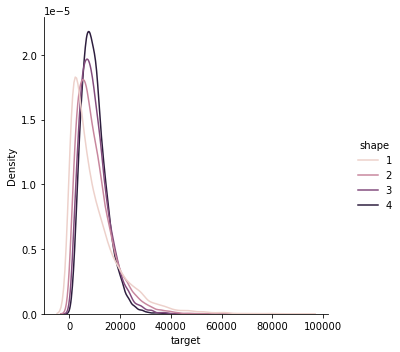

In [35]:
sns.displot(data = df, x = 'target', hue = 'shape', kind = 'kde')
plt.show()

# Distribution Fitting

## Method of Moments

The formula is quite simple, based on observed variance and mean. 

In [38]:
np.mean(df1.target)

9968.389169698938

In [39]:
(np.std(df1.target)) ** 2

100129238.087855

In [40]:
estimated_shape = np.mean(df1.target) **  2 / (np.std(df1.target)) ** 2
estimated_shape

0.9924052608028766

In [41]:
estimated_scale = (np.std(df1.target)) ** 2 / np.mean(df1.target)
estimated_scale

10044.675863199578

In [42]:
estimated_mean = estimated_shape * estimated_scale
estimated_mean

9968.389169698938

In [43]:
estimated_variance = estimated_shape * estimated_scale ** 2
estimated_variance

100129238.087855

OK, so this method seems to work. 

However, this is not the MLE estimation, MLE should be biased for gamma. 

## Maximum Likelihood Estimation

https://en.wikipedia.org/wiki/Gamma_distribution#Maximum_likelihood_estimation

There is no closed formula, just an approximation. 

In [44]:
def get_gamma_mle_scale(mle_shape, sample):
    # returns the estimated scale parameter, which is dependent on the estimated shape
    return np.mean(sample) / mle_shape

def get_gamma_approximate_mle_shape(sample):
    # returns an approximation of shape parameter
    s = np.log(np.mean(sample)) - np.mean(np.log(sample))
    return (3 - s + ((s-3)**2 + 24 * s) ** 0.5) / (12 * s)

In [45]:
mle_estimated_shape = get_gamma_approximate_mle_shape(df1.target)
mle_estimated_shape

0.981757389494321

In [46]:
mle_estimated_scale = get_gamma_mle_scale(mle_estimated_shape, df1.target)
mle_estimated_scale

10153.617661929093

In [47]:
mle_estimated_shape * mle_estimated_scale

9968.389169698938

OK, so we get the expected value right (of course, because that is how the scale is set), just not the shape parameter itself.

In [48]:
mle_estimated_shape * mle_estimated_scale**2

101215212.3344378

The variance of the estimated is a bit higher than the actual. 

# GLM

## Baseline

Let's see if we can fit the expected value. 

In [49]:
df1['dummy_feature'] = 1

In [50]:
mdl = GammaRegressor(alpha = 0)

In [51]:
mdl.fit(df1[['dummy_feature']], df1['target'])

GammaRegressor(alpha=0)

In [52]:
df1['pred'] = mdl.predict(df1[['dummy_feature']])

In [53]:
df1.pred[0]

9968.389169698925

## Linear Increase in Shape

We need a new data, this time, we'll have a continuous feature. 

Expected value: feature_1 / 1000 * 20

In [56]:
df_mdl = pd.DataFrame.from_dict({'feature_1' : np.repeat(range(1000,10001),100)})

df_mdl['shape'] = df_mdl['feature_1'] / 1000
df_mdl['scale'] = 20

df_mdl['claim_amount'] = np.random.gamma(shape = df_mdl['shape'], scale = df_mdl['scale'])
df_mdl['log_feature_1'] = np.log(df_mdl['feature_1'])

In [62]:
df_mdl['expected_value'] = df_mdl['shape'] * df_mdl['scale']

In [59]:
mdl = GammaRegressor(alpha = 0)
X = df_mdl[['log_feature_1']]
y = df_mdl['claim_amount']
mdl.fit(X, y)
df_mdl['pred_claim_amount'] = mdl.predict(X)

In [63]:
df_mdl.sample(5)

,feature_1,shape,scale,claim_amount,log_feature_1,pred_claim_amount,expected_value
154928,2549,0.2549,20,2.315253,7.843456,5.105743,5.098
853675,9536,0.9536,20,3.291487,9.162829,19.028179,19.072
496441,5964,0.5964,20,2.752717,8.693497,11.916767,11.928
396565,4965,0.4965,20,18.788054,8.510169,9.925913,9.930
99655,1996,0.1996,20,2.607379,7.598900,4.000894,3.992


In [64]:
mdl.coef_

array([0.99710622])

## Linear Increase in Scale

In [65]:
df_mdl = pd.DataFrame.from_dict({'feature_1' : np.repeat(range(1000,10001),100)})

df_mdl['scale'] = df_mdl['feature_1'] / 1000
df_mdl['shape'] = 20

df_mdl['claim_amount'] = np.random.gamma(shape = df_mdl['shape'], scale = df_mdl['scale'])
df_mdl['log_feature_1'] = np.log(df_mdl['feature_1'])

In [66]:
df_mdl['expected_value'] = df_mdl['shape'] * df_mdl['scale']

In [67]:
mdl = GammaRegressor(alpha = 0)
X = df_mdl[['log_feature_1']]
y = df_mdl['claim_amount']
mdl.fit(X, y)
df_mdl['pred_claim_amount'] = mdl.predict(X)

In [68]:
df_mdl.sample(5)

,feature_1,scale,shape,claim_amount,log_feature_1,expected_value,pred_claim_amount
458968,5589,5.589,20,88.033767,8.628556,111.78,111.758697
786289,8862,8.862,20,237.639250,9.089528,177.24,177.210679
78386,1783,1.783,20,32.571123,7.486053,35.66,35.650982
512896,6128,6.128,20,138.083346,8.720624,122.56,122.537258
421563,5215,5.215,20,113.464873,8.559294,104.30,104.279729


In [69]:
mdl.coef_

array([1.00005456])

## Constant Mean, but Changing Parameters

Main question: will GLM realise that the expected value remains constant if we increase one parameter and decrease the other? 

In [70]:
expected_value = 1000

df_mdl = pd.DataFrame.from_dict({'feature_1' : np.repeat(range(1000,10001),100)})

df_mdl['scale'] = df_mdl['feature_1'] / 1000
df_mdl['shape'] = expected_value / df_mdl['scale']

df_mdl['claim_amount'] = np.random.gamma(shape = df_mdl['shape'], scale = df_mdl['scale'])
df_mdl['log_feature_1'] = np.log(df_mdl['feature_1'])

In [71]:
df_mdl['expected_value'] = df_mdl['shape'] * df_mdl['scale']

In [72]:
mdl = GammaRegressor(alpha = 0)
X = df_mdl[['log_feature_1']]
y = df_mdl['claim_amount']
mdl.fit(X, y)
df_mdl['pred_claim_amount'] = mdl.predict(X)

In [73]:
df_mdl.sample(5)

,feature_1,scale,shape,claim_amount,log_feature_1,expected_value,pred_claim_amount
57971,1579,1.579,633.312223,974.863002,7.364547,1000.0,1000.034872
243894,3438,3.438,290.866783,1010.452274,8.142645,1000.0,1000.034872
852763,9527,9.527,104.964837,1127.751148,9.161885,1000.0,1000.034872
1469,1014,1.014,986.193294,1025.302285,6.921658,1000.0,1000.034872
190486,2904,2.904,344.352617,923.248651,7.973844,1000.0,1000.034872


In [74]:
mdl.coef_

array([0.])

## Shape and Scale Tied to Different Features

In [75]:
number_of_sample = 10000

In [76]:
df_mdl = pd.DataFrame.from_dict({'feature_1' : np.random.uniform(low = 1, high = 10, size = number_of_sample),
                                'feature_2' : np.random.uniform(low = 1000, high = 10000, size = number_of_sample)})

In [77]:
df_mdl['shape'] = df_mdl['feature_1']
df_mdl['scale'] = df_mdl['feature_2']

df_mdl['log_feature_1'] = np.log(df_mdl['feature_1'])
df_mdl['log_feature_2'] = np.log(df_mdl['feature_2'])

df_mdl['claim_amount'] = np.random.gamma(shape = df_mdl['shape'], scale = df_mdl['scale'])

In [78]:
df_mdl['expected_value'] = df_mdl['shape'] * df_mdl['scale']

In [81]:
mdl = GammaRegressor(alpha = 0)
X = df_mdl[['log_feature_1', 'log_feature_2']]
y = df_mdl['claim_amount']
mdl.fit(X, y)
df_mdl['pred_claim_amount'] = mdl.predict(X)

In [82]:
df_mdl.sample(5)

,feature_1,feature_2,shape,scale,log_feature_1,log_feature_2,claim_amount,expected_value,pred_claim_amount
8553,8.900922,3205.779423,8.900922,3205.779423,2.186155,8.072711,41504.053944,28534.393358,29076.232031
1822,9.130342,3621.464193,9.130342,3621.464193,2.211603,8.194634,18500.363159,33065.205992,33676.748026
9632,7.110421,3294.432582,7.110421,3294.432582,1.961562,8.099989,26385.289317,23424.803992,23729.717022
5841,3.121922,7754.539967,3.121922,7754.539967,1.138449,8.956034,47008.452299,24209.066342,23835.026165
3648,1.084508,7649.422100,1.084508,7649.422100,0.081126,8.942385,667.744006,8295.858424,7955.155301


In [83]:
mdl.coef_

array([1.02505466, 0.99079383])

## Summary

Behaved as expected on all test cases. Which is good. 